<a href="https://colab.research.google.com/github/haihttran/statistics/blob/master/%08Wood2_LTV_Android_US.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from scipy import stats
from fbprophet import Prophet

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Get number of users who joined game on 2019-10-16 and being active in 2019-10-17 -- 2020-10-16:



In [ ]:
%%bigquery --project haith-2913 df
SELECT TIMESTAMP_TRUNC(TIMESTAMP_MICROS(event_timestamp), DAY) AS day,
      COUNT(DISTINCT user_pseudo_id) AS user_count,
      FROM `wood-2.analytics_155124895.events_*`
      WHERE 
        event_name in ('user_engagement','session_start')
        AND _TABLE_SUFFIX BETWEEN '20191014' AND '20201017'
        AND FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_MICROS(event_timestamp), DAY))
        BETWEEN '20191017' AND '20201016'
        AND FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_MICROS(user_first_touch_timestamp), DAY)) 
        = '20191016'
        AND platform = 'ANDROID'
        AND geo.country = 'United States'
  GROUP BY day
  ORDER BY 1

Get number of user who join game on 2020-10-16:

In [ ]:
%%bigquery --project haith-2913 n
SELECT
    COUNT(DISTINCT user_pseudo_id) AS n,
    FROM `wood-2.analytics_155124895.events_*`
    WHERE 
      _TABLE_SUFFIX BETWEEN '20191015' AND '20201017'
      AND FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_MICROS(user_first_touch_timestamp), DAY)) 
      = '20191016'
      AND platform = 'ANDROID'
      AND geo.country = 'United States'

Count the number of unique users who joined our game on October 17th, 2019:

In [ ]:
n.iloc[0][0]

34

We compute respective retention rate for each day in 365-day period and add these values to the dataframe df as column 'retention_rate':

In [ ]:
df.insert(len(df.columns), str("retention_rate").strip(), df.user_count/n.iloc[0][0]) 

In [ ]:
df

,day,user_count,retention_rate
0,2019-10-17 00:00:00+00:00,10,0.294118
1,2019-10-18 00:00:00+00:00,7,0.205882
2,2019-10-19 00:00:00+00:00,6,0.176471
3,2019-10-20 00:00:00+00:00,8,0.235294
4,2019-10-21 00:00:00+00:00,10,0.294118
...,...,...,...
357,2020-10-12 00:00:00+00:00,6,0.176471
358,2020-10-13 00:00:00+00:00,3,0.088235
359,2020-10-14 00:00:00+00:00,4,0.117647
360,2020-10-15 00:00:00+00:00,2,0.058824


The plot retention rate of 365 consecutive days 10/2019 - 10/2020:

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 8 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 8 missing from current font.



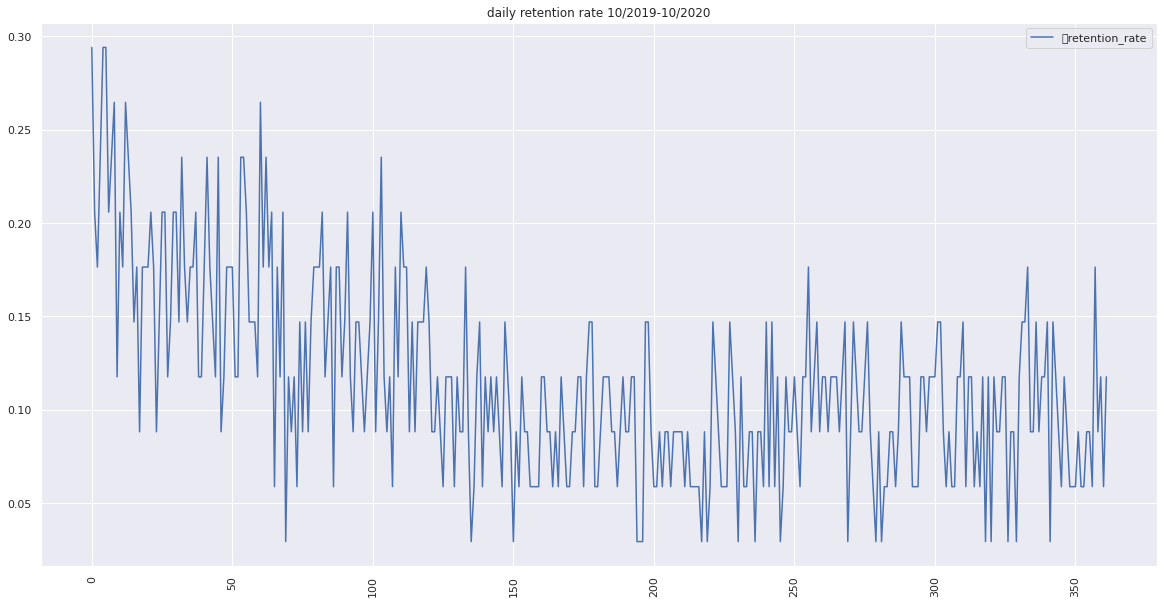

In [ ]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(20, 10))
sns.lineplot(data=df.iloc[:,2:])
plt.xticks(rotation=90)
plt.title('daily retention rate 10/2019-10/2020')
plt.show()

Find the number of users being active on 2020-10-17 and joined game in 2019-10-17 -- 2020-10-16:

In [ ]:
%%bigquery --project haith-2913 df2

  SELECT TIMESTAMP_TRUNC(TIMESTAMP_MICROS(user_first_touch_timestamp), DAY) AS day,
      COUNT(DISTINCT user_pseudo_id) AS user_count,
      FROM `wood-2.analytics_155124895.events_*`
      WHERE 
        event_name in ('user_engagement','session_start')
        AND _TABLE_SUFFIX BETWEEN '20191016' AND '20201018'
        AND FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_MICROS(event_timestamp), DAY))
        = '20201016'
        AND FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_MICROS(user_first_touch_timestamp), DAY)) 
        BETWEEN '20191016' AND '20201015'
        AND platform = 'ANDROID'
        AND geo.country = 'United States'
  GROUP BY day
  ORDER BY 1

In [ ]:
df2

,day,user_count
0,2019-10-16 00:00:00+00:00,4
1,2019-10-18 00:00:00+00:00,3
2,2019-10-19 00:00:00+00:00,1
3,2019-10-20 00:00:00+00:00,3
4,2019-10-22 00:00:00+00:00,2
...,...,...
318,2020-10-11 00:00:00+00:00,5
319,2020-10-12 00:00:00+00:00,6
320,2020-10-13 00:00:00+00:00,1
321,2020-10-14 00:00:00+00:00,4


The accomulative number of users who joined the game throughout the period of 365 days from 17-10-2019 to 16-10-2020 and being active on September 1st, 2020:

In [ ]:
df2.user_count.sum()

864

We then count the total number of active users on date October 17th, 2020:

In [ ]:
%%bigquery --project haith-2913 df3

SELECT
  COUNT(DISTINCT user_pseudo_id) AS total_202009
  FROM `wood-2.analytics_155124895.events_*`
  WHERE 
    event_name in ('user_engagement','session_start')
    AND _TABLE_SUFFIX BETWEEN '20201015' AND '20201017'
    AND FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_MICROS(event_timestamp), DAY))
    = '20201016'
    AND platform = 'ANDROID'
    AND geo.country = 'United States'
ORDER BY 1

And we count the number of active users who joined game on October 17th, 2020:

In [ ]:
%%bigquery --project haith-2913 df4
#Get number of users who joined game on 2020-10-17 and being active on that day
SELECT
  COUNT(DISTINCT user_pseudo_id) AS total_202009
  FROM `wood-2.analytics_155124895.events_*`
  WHERE 
    event_name in ('user_engagement','session_start')
    AND _TABLE_SUFFIX BETWEEN '20201015' AND '20201017'
    AND FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_MICROS(event_timestamp), DAY))
    = '20201016'
    AND FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_MICROS(user_first_touch_timestamp), DAY)) 
    ='20201016'
    AND platform = 'ANDROID'
    AND geo.country = 'United States'
ORDER BY 1

Calculate:


*   Number of users being active on 2020-10-17 and joined game within 1 year ago
*   Number of users who being active on 2020/10-17 and joined game more than 1 year ago
*   Total number of users being active on 2020-10-17





In [ ]:
#  Total number of user being active on October 17th, 2020
total = df3.iloc[0][0].astype(int)
#  Accumulated retained users joined game in the period
# of 365 consecutive days before
accu_users_365 = df2.user_count.sum().astype(int)
#  Active user who joined game on October 17th, 2020
sept_new_users = df4.iloc[0][0]
#  Remain: the number of users who joined more than 1 year ago, or loyal base
remain = total - accu_users_365 - sept_new_users

Check the ratio of 365-day accumulated retained users over total number of active users on September 1st, 2020:

In [ ]:
accu_users_365/total

0.22712933753943218

And the ratio of number of users who joined more than 1 year ago over total number of active users:

In [ ]:
remain/total

0.7649842271293376

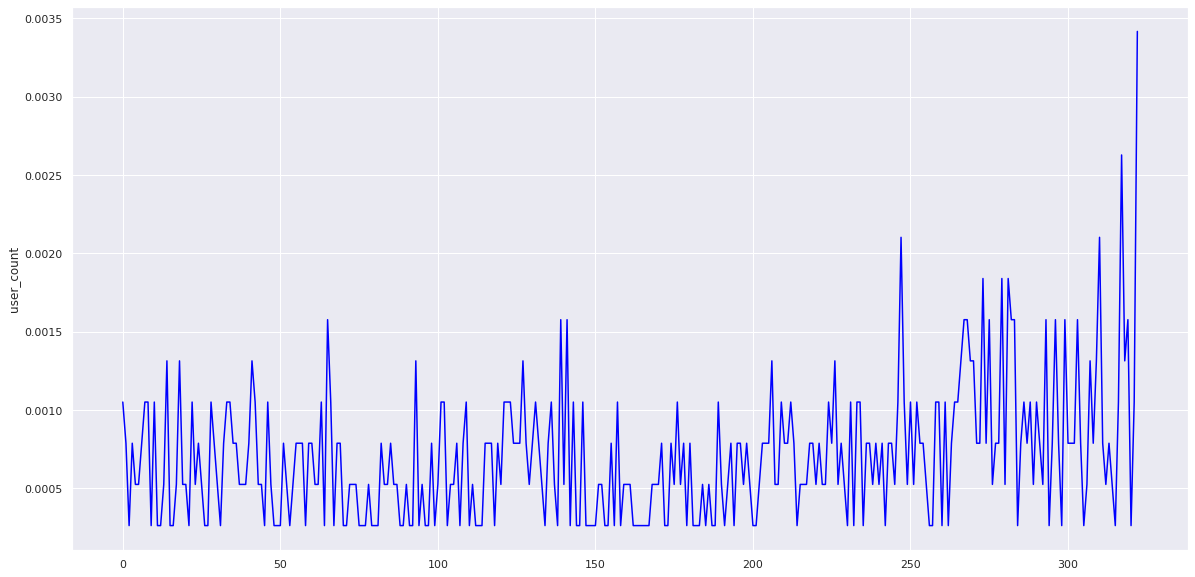

In [ ]:
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(20, 10))
sns.lineplot(data=df2.user_count/total, color='blue')
# plt.title(' of')
plt.show()

Let's calculate the accumulative value of retention rate over 365 days:

In [ ]:
rr = df['retention_rate'].sum() #accumulated retention rate

In [ ]:
rr

41.588235294117645

The ratio of the loyal base and accumulated retained users during 365 days:

In [ ]:
ratio = (remain/accu_users_365)

In [ ]:
ratio

3.3680555555555554

Data model for calculating number of daily active users of a particular day, given the number x of average new users who join the game over: 

In [ ]:
f = lambda x : x*(1+ratio)*rr
g = lambda x : f(x) + x

Now, we check the model with retrospective data. We pull data of the last immediate 6 months of 2020 and get the average number of daily newly joined users:

In [ ]:
%%bigquery --project haith-2913 mean_daily_new_user

WITH B AS (
  SELECT
    FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_MICROS(user_first_touch_timestamp), MONTH)) as month,
    COUNT(DISTINCT user_pseudo_id) AS n,
      FROM `wood-2.analytics_155124895.events_*`
      WHERE 
        _TABLE_SUFFIX BETWEEN '20200416' AND '20201017'
        AND FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_MICROS(user_first_touch_timestamp), DAY)) 
        BETWEEN '20200417' AND '20201016' 
        AND platform = 'ANDROID'
        AND geo.country = 'United States'
--         AND event_name in ('user_engagement','session_start')
  GROUP BY month
)
SELECT AVG(n)/30 as result FROM B

In [ ]:
mean_daily_new_user.iloc[0][0]

22.05714285714286

Then we compute the retained users of the September 1st, 2020 based on the newly got average daily new user number:

the forecasted value of retained users on September 1st, 2020:

In [ ]:
f(mean_daily_new_user.iloc[0][0])

4006.8944444444446

In [ ]:
accu_users_365 + remain

3774

Then we compute the value of daily active user of September 1st, 2020 and compare with real value we got before:

In [ ]:
g(mean_daily_new_user.iloc[0][0])

4028.9515873015876

# Calculate LTV of US market:

Calculate 1-year revenue Wood2 Android version on US market

In [ ]:
%%bigquery --project haith-2913 ltv_1

DECLARE fromdate TIMESTAMP DEFAULT '2019-10-16 00:00:00';
DECLARE todate TIMESTAMP DEFAULT '2020-10-15 00:00:00';

WITH A AS (
  SELECT internal_app_id, report_date, revenue, country
    FROM `haith-2913.revenue_wood2.tab_rev`
    WHERE country = 'US'
      AND FORMAT_DATE('%Y%m%d', report_date)
      BETWEEN FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_SUB(fromdate, INTERVAL 1 DAY), DAY)) 
      AND FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_ADD(todate, INTERVAL 1 DAY), DAY))
      AND internal_app_id = 'id1164022904'
  ORDER BY 1,2
),
B AS (
  SELECT internal_app_id, report_date, revenue, country
    FROM `haith-2913.revenue_wood2.tab_rev`
    WHERE country = 'US'
      AND FORMAT_DATE('%Y%m%d', report_date)
      BETWEEN FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_SUB(fromdate, INTERVAL 1 DAY), DAY)) 
      AND FORMAT_TIMESTAMP('%Y%m%d', TIMESTAMP_TRUNC(TIMESTAMP_ADD(todate, INTERVAL 1 DAY), DAY))
      AND internal_app_id = 'game.puzzle.woodenblockpuzzle'
  ORDER BY 1,2
)
SELECT A.report_date as date, A.internal_app_id AS ios_app, A.revenue AS ios_rev, 
       B.internal_app_id AS android_app, B.revenue AS android_rev, B.country AS country
  FROM A join B
  ON A.report_date = B.report_date
ORDER BY date

In [ ]:
ltv_1

,date,ios_app,ios_rev,android_app,android_rev,country
0,2019-10-15,id1164022904,822.59389914,game.puzzle.woodenblockpuzzle,325.38132323,US
1,2019-10-16,id1164022904,696.90832764,game.puzzle.woodenblockpuzzle,326.69551288,US
2,2019-10-17,id1164022904,696.10124314,game.puzzle.woodenblockpuzzle,338.70305156,US
3,2019-10-18,id1164022904,647.56956092,game.puzzle.woodenblockpuzzle,360.48569039,US
4,2019-10-19,id1164022904,709.08389924,game.puzzle.woodenblockpuzzle,369.10725163,US
...,...,...,...,...,...,...
363,2020-10-12,id1164022904,699.049228,game.puzzle.woodenblockpuzzle,319.215883,US
364,2020-10-13,id1164022904,698.691427,game.puzzle.woodenblockpuzzle,349.568207,US
365,2020-10-14,id1164022904,743.037423,game.puzzle.woodenblockpuzzle,336.226929,US
366,2020-10-15,id1164022904,728.620919,game.puzzle.woodenblockpuzzle,339.139531,US


In [ ]:
arpdau_android = float(ltv_1.android_rev.sum())/(g(mean_daily_new_user.iloc[0][0])*365)

In [ ]:
arpdau_android

0.08184118547065278

In [ ]:
arpdau_android * rr #rr is the average user-days, or the cummulative sum under the retention rate curve

3.40363047810303